In [2]:
import folium
import pandas as pd
import numpy as np
import os
import json
import itertools
import matplotlib.pyplot as plt
import branca.colormap as cm
import seaborn as sns
import ipywidgets as widgets
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from branca.colormap import linear

%matplotlib inline

This cell below is copied from https://gist.github.com/llimllib/4974446

It is used to compute the Jenks classification, which is a data clustering method designed to determine the best arrangement of values into different classes.


In [3]:

import json
from pprint import pprint as pp

def jenks_matrices_init(data, n_classes):
    #fill the matrices with data+1 arrays of n_classes 0s
    lower_class_limits = []
    variance_combinations = []
    for i in range(0, len(data)+1):
        temp1 = []
        temp2 = []
        for j in range(0, n_classes+1):
            temp1.append(0.)
            temp2.append(0.)
        lower_class_limits.append(temp1)
        variance_combinations.append(temp2)

    inf = float('inf')
    for i in range(1, n_classes+1):
        lower_class_limits[1][i] = 1.
        variance_combinations[1][i] = 0.
        for j in range(2, len(data)+1):
            variance_combinations[j][i] = inf

    return lower_class_limits, variance_combinations

def jenks_matrices(data, n_classes):
    lower_class_limits, variance_combinations = jenks_matrices_init(data, n_classes)

    variance = 0.0
    for l in range(2, len(data)+1):
        sum = 0.0
        sum_squares = 0.0
        w = 0.0
        for m in range(1, l+1):
            # `III` originally
            lower_class_limit = l - m + 1
            val = data[lower_class_limit-1]

            # here we're estimating variance for each potential classing
            # of the data, for each potential number of classes. `w`
            # is the number of data points considered so far.
            w += 1

            # increase the current sum and sum-of-squares
            sum += val
            sum_squares += val * val

            # the variance at this point in the sequence is the difference
            # between the sum of squares and the total x 2, over the number
            # of samples.
            variance = sum_squares - (sum * sum) / w

            i4 = lower_class_limit - 1

            if i4 != 0:
                for j in range(2, n_classes+1):
                    if variance_combinations[l][j] >= (variance + variance_combinations[i4][j - 1]):
                        lower_class_limits[l][j] = lower_class_limit
                        variance_combinations[l][j] = variance + variance_combinations[i4][j - 1]

        lower_class_limits[l][1] = 1.
        variance_combinations[l][1] = variance

    return lower_class_limits, variance_combinations

def get_jenks_breaks(data, lower_class_limits, n_classes):
    k = len(data) - 1
    kclass = [0.] * (n_classes+1)
    countNum = n_classes

    kclass[n_classes] = data[len(data) - 1]
    kclass[0] = data[0]

    while countNum > 1:
        elt = int(lower_class_limits[k][countNum] - 2)
        kclass[countNum - 1] = data[elt]
        k = int(lower_class_limits[k][countNum] - 1)
        countNum -= 1

    return kclass

def jenks(data, n_classes):
    if n_classes > len(data): return

    data.sort()

    lower_class_limits, _ = jenks_matrices(data, n_classes)

    return get_jenks_breaks(data, lower_class_limits, n_classes)

# Part 1

After searching for a while on the eurostat website, we decided to take statistics for unemployment rate that contain data for all members of the UE over several years for the group age 20-64. We used eurostat's feature to filter the data we wanted to avoid having to clean it in Python (for example with English country names for merging with the topojson, no annotations, no footnotes, ...). Like this, the setup is simple and the data immediately usable without too much processing.

From the data we found, unemployment is defined as follows:

"The indicator presents unemployment rates for different age groups. The unemployment rate represents unemployed persons as a percentage of the labour force. The labour force is the total number of people employed and unemployed. The indicator is based on the EU Labour Force Survey."

In [4]:
europe_data_path =  os.path.join('data', 'lfsa_urgaed_1_Data.csv')
europe_data_original = pd.DataFrame.from_csv(europe_data_path, sep=',')

europe_data = europe_data_original.copy()

# Two country names are different in the topojson so we replace them accordingly
europe_data['GEO'] = europe_data['GEO'].astype('str').replace('Germany.+','Germany', regex=True)
europe_data['GEO'] = europe_data['GEO'].astype('str').replace('.+Yugoslav.+','The former Yugoslav Republic of Macedonia', regex=True)

# Keep only the needed columns (country and rate)
europe_data.index = europe_data['GEO']
europe_data = europe_data[['GEO','Value']]

europe_data.head()

,GEO,Value
GEO,,
Belgium,Belgium,7.7
Bulgaria,Bulgaria,7.6
Czech Republic,Czech Republic,3.9
Denmark,Denmark,5.7
Germany,Germany,4.1


We decided to classify the data into classes using Jenks classification, which splits data into n classes such that the variance in each class is minimized. This allows better vizualization than say linear separation of the classes. We found an implementation of Jenks classification for Python2, which we adapted for Python3 ( see beginning of this notebook).

In [5]:
# the number of classes we want
n_classes = 6

europe_values = europe_data['Value'].values

# Finds the index of a value in an array representing ranges
def find_index_first_greater_than(x, jenks_class):
    return next(itertools.chain(iter(i for i,v in enumerate(jenks_class) if x <= v), [len(jenks_class)-1]))

jenks_class = jenks(europe_values.copy(), n_classes)
jenks_class[0] = 2.7 # TODO hack

# For example, below we print the Jenks classification limits, and the index of a value
ind = find_index_first_greater_than(15,jenks_class)
print(jenks_class)
print(ind)


[2.7, 5.0, 6.7999999999999998, 9.8000000000000007, 12.9, 19.300000000000001, 23.5]
5


We create a new column in the dataframe with the class of each data value, computed with the above function and Jenks classification:

In [6]:
europe_data['class'] = europe_data['Value'].apply(lambda x: find_index_first_greater_than(x,jenks_class)-1)

europe_data.sort_values('Value').tail()

,GEO,Value,class
GEO,,,
Croatia,Croatia,12.5,3
Cyprus,Cyprus,12.9,3
Spain,Spain,19.3,4
The former Yugoslav Republic of Macedonia,The former Yugoslav Republic of Macedonia,23.4,5
Greece,Greece,23.5,5


For the number of classes set above, we display the data (all possible values for unemployment rate) in a histogram with the color corresponding to their class.

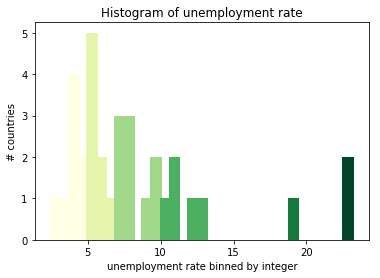

In [7]:
colormap_europe = plt.get_cmap('YlGn', n_classes)

Y,X = np.histogram(europe_values, len(europe_values))
C = [colormap_europe(find_index_first_greater_than(x, jenks_class)-1) for x in X]

plt.bar(X[:-1], Y, color=C)
plt.title('Histogram of unemployment rate')
plt.xlabel('unemployment rate binned by integer')
plt.ylabel('# countries')
plt.show()


As we can see, Jenks separates classes in a satisfactory manner.

It's even easier to visualize the separation created by Jenks classification with the following bar chart:

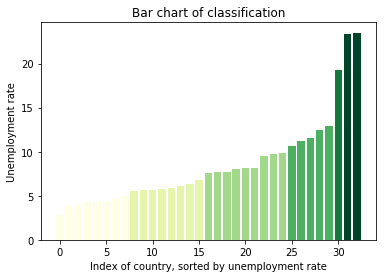

In [8]:
class_to_color_map = {c: colormap_europe(c) for c in range(n_classes)}
cc = [class_to_color_map[c] for c in europe_data['class'].sort_values().values]

plt.bar(range(len(europe_values)), np.sort(europe_values), color=cc)
plt.title('Bar chart of classification')
plt.xlabel('Index of country, sorted by unemployment rate')
plt.ylabel('Unemployment rate')
plt.show()

We can plot the number of members by class

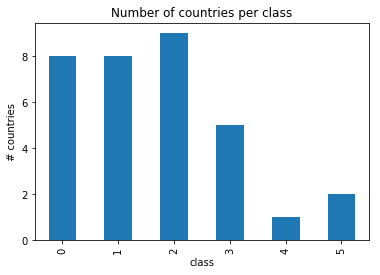

In [9]:
elplot = europe_data['class'].value_counts().sort_index().plot.bar()
elplot.set_title('Number of countries per class')
elplot.set_xlabel('class')
elplot.set_ylabel('# countries')

Now we can plot the map of Europe with correct colors for unemployment rate by country.

We center the map on the geographical center of Europe, which is in Suchowola in Poland, where a monument commemorates the fact. We use a styling function to colorize the countries based on the analysis we did above. With Folium it is then easy to display everything with the corresponding colormap.

In [10]:
europe_topojson_path = os.path.join('topojson', 'europe.topojson.json')

europe_topojson = json.load(open(europe_topojson_path))

# Create the base map
europe_geo_center = [53.5775, 23.106111]
europe_map = folium.Map(
    location=europe_geo_center,
    tiles='Mapbox Bright',
    zoom_start=4
)

# Create the dictionary for country _> color
country_to_class_dict = europe_data.set_index("GEO")["class"]
country_to_color_dict = {country_: class_to_color_map[class_] for country_, class_ in country_to_class_dict.items()}


def select_color(country):
    if country in country_to_color_dict:
        return country_to_color_dict[country]
    else:
        return 0.0

def select_opacity(country):
    if country in country_to_color_dict:
        return 0.1
    else:
        return 0.0
    
# Styling function used to colorize the country
def europe_style_function(x):
    country = x['properties']['NAME']
    
    return {'fillColor': select_color(country),
            'fillOpacity': select_opacity(country)}

europe_map.choropleth(geo_data=europe_topojson, data=europe_data,
                   name='choropleth',
                   columns=['GEO','Value'],
                   key_on='feature.properties.NAME',
                   fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
                   topojson='objects.europe')

folium.TopoJson(
    europe_topojson,
    'objects.europe',
    style_function=europe_style_function
).add_to(europe_map)

# Add the legend with Jenks classification
cm.StepColormap(
    list(class_to_color_map.values()),
    vmin=europe_values.min(), vmax=europe_values.max(),
    index=jenks_class,
    caption='Unemployment rate (%)'
).add_to(europe_map)

folium.LayerControl().add_to(europe_map)

europe_map

Note that light yellow color means missing/no data, as described above, and we used n=6 classes.

To verify our map we can compare with the one on the eurostat page (http://ec.europa.eu/eurostat/tgm/mapToolClosed.do?tab=map&init=1&plugin=1&language=en&pcode=tepsr_wc170&toolbox=types#) where we got our data or other maps on internet to verify the correctness of the data.

Switzerland's unemployment rate is about the same (i.e. is in the same class) as many of the other countries surrounding it: North-East the countries have the same class, and South-West they are one class above the unemployment rate threshold.

In [11]:
def europe_map(numberClasses):
    n_classes = numberClasses
    print(n_classes)
    
    # TODO
    '''
    europe_values = europe_data['Value'].values

    jenks_class = jenks(europe_values.copy(), n_classes)
    jenks_class[0] = 2.7 # TODO hack
    '''

number_classes = widgets.Dropdown(
    options=range(8),
    value=6,
    description='Number of classes:',
    disabled=False,
)


interact(europe_map, numberClasses = number_classes)


interactive(children=(Dropdown(description='Number of classes:', index=6, options=(0, 1, 2, 3, 4, 5, 6, 7), value=6), Output()), _dom_classes=('widget-interact',))

<function __main__.europe_map>

# TODO
- add interaction: year, and number of classes
- native folium threshold function

# Part 2

Getting the Switzerland unemployement data from the provided website was a bit tricky. We first had to specify the encoding to utf-16. And also manually edit the csv file to remove the "month" and "total" element which appears to be a second layer of header which we don't need. We also rename the canton to match the json file. Il could be automaticly done with a maping, or with adding a new column with canton id.

In [12]:

#Set the path and load the Json data.
swiss_topojson_path = os.path.join('topojson', 'ch-cantons.topojson.json')

#Load the map with a correct zoom on Switzerland.
swiss_map = folium.Map(location = [46.8, 8.227], tiles='Mapbox Bright', zoom_start = 8)

#Load the Switzerland unemployement's data.
swiss_unemployement_Sept2017 = os.path.join('data', 'swiss_unemployement_2.csv')
swiss_unemployement = pd.read_csv(swiss_unemployement_Sept2017, sep=';', encoding="utf-16")
swiss_unemployement = swiss_unemployement.drop('Mesures', 1).drop('Taux de chômage.1', 1).drop('Chômeurs inscrits.1', 1).drop("Demandeurs d'emploi.1", 1).drop("Demandeurs d'emploi non chômeurs.1", 1)

#Create a dictionnary in order to map a "canton" to its unemployement rate .
swiss_unemp_dict = swiss_unemployement.set_index("Canton")["Taux de chômage"]

#Create a colormap
colormap = linear.YlGn.scale(0, swiss_unemployement["Taux de chômage"].max())

#Create a dictionnary of color based on our "canton" - unemployement rate dictionnary.
color_dict = {key: colormap(swiss_unemp_dict[key]) for key in swiss_unemp_dict.keys()}

#The color function to apply on our "canton".
style_function = lambda x: {'fillColor': color_dict[x['properties']['name']],
                            'fillOpacity': 0.9,
                           }

folium.TopoJson(open(swiss_topojson_path, encoding="utf-8"),
                'objects.cantons',
                name='topojson',
                style_function=style_function
               ).add_to(swiss_map)

colormap.caption = 'Unemployment color scale in percent [%]'
colormap.add_to(swiss_map)

#save the map as an html element to show it on GitHub.
swiss_map.save(os.path.join('results', 'GeoJSON_SwissMap_1.html'))

swiss_map

### Part 3
Assumptions:
 - Unemployement rate = ( number of unemployed people / nuber of active population ) * 100
 - Unemployed people age 25 and above registered in ORP (recent graduates are not included) ( includes people looking for a job)
 - Active population includes all people working at least one hour per week or not.
 

From the amstat website we fetch the data, since we stick to the offecial definitian of unemployment rate, we can direct take the values from the 2.1 section on the amstat. Therefore we take the unemplyment rate per nationality per canton for the past year, that we define as from September 2016 to September 2017. This range of months is later used for the interactive map.
In order to facilitate our work with the topoJSON file later on, we start with the data file in German. Moreover this file contains data for the whole past year. However we are going to keep track of most recent month, assuming that the interest of the stuty is to observe and conclude upon current situation. However we do take a look at general year dynamic later.

In [13]:
# Load the data
suisse_nat_xls_data_path =  os.path.join('data', '2_1_Arbeitslosenquoten.xlsx')
suisse_nat = pd.read_excel(suisse_nat_xls_data_path, sheetname='2.1 Arbeitslosenquoten', header=5)
# Clean up some useless columns
suisse_nat.drop(['Monat'], axis=1, inplace = True)
suisse_nat.drop(['Gesamt'], axis=1, inplace = True)
suisse_nat.head(5)

,Kanton,Nationalität,September 2016,Oktober 2016,November 2016,Dezember 2016,Januar 2017,Februar 2017,März 2017,April 2017,Mai 2017,Juni 2017,Juli 2017,August 2017,September 2017
0,Zürich,Ausländer,5.7,5.8,6.1,6.4,6.6,6.5,6.3,6.0,5.7,5.6,5.5,5.3,5.3
1,Zürich,Schweizer,2.8,2.8,2.8,2.9,2.9,2.8,2.8,2.7,2.6,2.6,2.6,2.6,2.5
2,Bern,Ausländer,5.9,6.3,6.9,7.3,7.5,7.4,7.1,6.8,6.2,5.7,5.5,5.5,5.5
3,Bern,Schweizer,2.0,2.0,2.0,2.1,2.2,2.1,2.1,2.0,1.9,1.8,1.8,1.9,1.8
4,Luzern,Ausländer,4.2,4.2,4.6,5.1,5.4,5.1,4.8,4.6,4.3,4.1,3.9,3.9,3.9


We take note that 'Schweizer' means 'Swiss' and 'Ausländer' means 'foreigner'.

Now that the data is in good shape let's see if any formating is required.

In [14]:
suisse_nat.dtypes

Kanton             object
Nationalität       object
September 2016    float64
Oktober 2016      float64
November 2016     float64
Dezember 2016     float64
Januar 2017       float64
Februar 2017      float64
März 2017         float64
April 2017        float64
Mai 2017          float64
Juni 2017         float64
Juli 2017         float64
August 2017       float64
September 2017    float64
dtype: object

Formats look good. However there is the last row for the total unemployment rate accross Switzerland, for now we'll keep it, but further on, we should discart it.

In [15]:
suisse_nat.tail(3)

,Kanton,Nationalität,September 2016,Oktober 2016,November 2016,Dezember 2016,Januar 2017,Februar 2017,März 2017,April 2017,Mai 2017,Juni 2017,Juli 2017,August 2017,September 2017
50,Jura,Ausländer,10.2,10.2,10.4,11.5,11.9,11.5,10.7,10.0,9.5,9.4,9.5,9.5,9.0
51,Jura,Schweizer,3.6,3.6,3.6,3.9,4.1,4.1,3.8,3.7,3.5,3.4,3.4,3.8,3.6
52,Gesamt,NaN,3.2,3.2,3.3,3.5,3.7,3.6,3.4,3.3,3.1,3.0,3.0,3.0,3.0


In [16]:
# Here we create a version with unique hierarchical index, it turned out to be useless at the end.
suisse_nat_hier = suisse_nat.copy()
suisse_nat_hier = suisse_nat_hier.set_index(['Kanton', 'Nationalität'])
suisse_nat_hier.head(5)

September 2016  Oktober 2016  November 2016  \
Kanton Nationalität                                                
Zürich Ausländer                5.7           5.8            6.1   
       Schweizer                2.8           2.8            2.8   
Bern   Ausländer                5.9           6.3            6.9   
       Schweizer                2.0           2.0            2.0   
Luzern Ausländer                4.2           4.2            4.6   

                     Dezember 2016  Januar 2017  Februar 2017  März 2017  \
Kanton Nationalität                                                        
Zürich Ausländer               6.4          6.6           6.5        6.3   
       Schweizer               2.9          2.9           2.8        2.8   
Bern   Ausländer               7.3          7.5           7.4        7.1   
       Schweizer               2.1          2.2           2.1        2.1   
Luzern Ausländer               5.1          5.4           5.1        4.8   

                     April 2017  Mai 2017  Juni 2017  Juli 2017  August 2017  \
Kanton Nationalität                                                            
Zürich Ausländer            6.0       5.7        5.6        5.5          5.3   
       Schweizer            2.7       2.6        2.6        2.6          2.6   
Bern   Ausländer            6.8       6.2        5.7        5.5          5.5   
       Schweizer            2.0       1.9        1.8        1.8          1.9   
Luzern Ausländer            4.6       4.3        4.1        3.9          3.9   

                     September 2017  
Kanton Nationalität                  
Zürich Ausländer                5.3  
       Schweizer                2.5  
Bern   Ausländer                5.5  
       Schweizer                1.8  
Luzern Ausländer                3.9

Now here is the interesting part. The names of cantons in the topoJSON file are given in French, Italian and German. This makes it hard to match our data to the geometries on the graph. Our strategy is to build a dictionary from canton names in German (in our data) to the canton names in languages in topoJSON file. There are little optimizations such as reducing the set of names to match to as we go. Eventhough this technique is relatively successful, there are a couple of exceptions that need to be dealt with manulaly.

In [17]:
import difflib
suisse_topojson_path = os.path.join('topojson', 'ch-cantons.topojson.json')
suisse_topojson = json.load(open(suisse_topojson_path))
cantonNames = []
for name in suisse_topojson['objects']['cantons']['geometries']:
    cantonNames.append(name['properties']['name'])
    #cantons.append(name)
cantonNames
#Get index of canton, get canton, compare to all, put the other one
cantonTranslation = []
cantonSeen = []
# append exceptions
cantonTranslation.append(('Waadt', 'Vaud'))
cantonTranslation.append(('Neuenburg', 'Neuchâtel'))
cantonTranslation.append(('Gesamt', 'Gesamt'))
cantons = suisse_nat.Kanton.copy()
cantons.drop_duplicates(inplace=True)
for canton1 in cantons:
    max = 0
    match = None
    a = canton1.lower()
    a = a.split('/')[0]
    if ((a != 'waadt') & (a != 'neuenburg') & (a != 'gesamt')):
        for canton2 in cantonNames:
            b = canton2.lower()
            b = b.split('/')[0]
            seq=difflib.SequenceMatcher(None, a, b)
            diff = seq.ratio()
            if max < diff:
                max = diff
                match = (canton1, canton2)
        cantonNames.remove(match[1])
    if (match is not None):
        cantonTranslation.append(match)
cantonTranslationDict = dict(cantonTranslation)
print(cantonTranslationDict)

{'Waadt': 'Vaud', 'Neuenburg': 'Neuchâtel', 'Gesamt': 'Gesamt', 'Zürich': 'Zürich', 'Bern': 'Bern/Berne', 'Luzern': 'Luzern', 'Uri': 'Uri', 'Schwyz': 'Schwyz', 'Obwalden': 'Obwalden', 'Nidwalden': 'Nidwalden', 'Glarus': 'Glarus', 'Zug': 'Zug', 'Freiburg': 'Fribourg', 'Solothurn': 'Solothurn', 'Basel-Stadt': 'Basel-Stadt', 'Basel-Landschaft': 'Basel-Landschaft', 'Schaffhausen': 'Schaffhausen', 'Appenzell Ausserrhoden': 'Appenzell Ausserrhoden', 'Appenzell Innerrhoden': 'Appenzell Innerrhoden', 'St. Gallen': 'St. Gallen', 'Graubünden': 'Graubünden/Grigioni', 'Aargau': 'Aargau', 'Thurgau': 'Thurgau', 'Tessin': 'Ticino', 'Wallis': 'Valais/Wallis', 'Genf': 'Genève', 'Jura': 'Jura'}


Now that we have a dictionary, we can replace the names of cantons in the main dataFrame.

In [18]:
suisse_nat["Kanton"] = suisse_nat["Kanton"].replace(cantonTranslationDict, inplace=False)
suisse_nat.tail(10)

,Kanton,Nationalität,September 2016,Oktober 2016,November 2016,Dezember 2016,Januar 2017,Februar 2017,März 2017,April 2017,Mai 2017,Juni 2017,Juli 2017,August 2017,September 2017
43,Vaud,Schweizer,3.6,3.6,3.6,3.7,3.8,3.7,3.6,3.5,3.4,3.4,3.5,3.6,3.5
44,Valais/Wallis,Ausländer,6.0,6.4,7.9,11.9,12.2,10.5,8.3,7.7,6.3,5.2,5.0,5.1,4.9
45,Valais/Wallis,Schweizer,2.3,2.3,2.4,2.8,2.8,2.7,2.4,2.3,2.3,2.1,2.2,2.2,2.1
46,Neuchâtel,Ausländer,8.7,8.6,9.1,10.4,10.7,10.5,9.8,9.0,8.4,7.6,7.6,7.5,7.4
47,Neuchâtel,Schweizer,4.6,4.6,4.6,4.7,4.9,4.9,4.7,4.6,4.4,4.2,4.3,4.3,4.2
48,Genève,Ausländer,6.2,6.3,6.2,6.3,6.5,6.4,6.2,6.0,5.9,5.8,5.7,5.7,5.7
49,Genève,Schweizer,5.0,5.0,4.9,4.9,5.0,4.8,4.8,4.7,4.6,4.6,4.7,4.8,4.8
50,Jura,Ausländer,10.2,10.2,10.4,11.5,11.9,11.5,10.7,10.0,9.5,9.4,9.5,9.5,9.0
51,Jura,Schweizer,3.6,3.6,3.6,3.9,4.1,4.1,3.8,3.7,3.5,3.4,3.4,3.8,3.6
52,Gesamt,NaN,3.2,3.2,3.3,3.5,3.7,3.6,3.4,3.3,3.1,3.0,3.0,3.0,3.0


Now let's see if there is anything interesting in the change of unemplyment over the year.

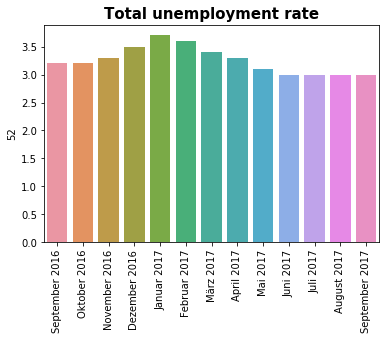

In [19]:
suisse_nat_copy = suisse_nat.copy()
suisse_nat_copy.drop(['Kanton'], axis=1, inplace = True)
suisse_nat_copy.drop(['Nationalität'], axis=1, inplace = True)
#suisse_nat_copy.drop(['Gesamt'], axis=1, inplace = True)
fig, ax = plt.subplots()
ax.set_title('Total unemployment rate', fontsize=15, fontweight='bold')
sns.barplot(suisse_nat_copy.iloc[52].keys(), suisse_nat_copy.iloc[52], ax=ax)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()
#suisse_nat_copy[:10].keys()

It appears that the highest unemployment is in January. This is quite normal for unemployment statistics and is due to seasonal patterns caused by many factors such as holidays, short-term contracts, harvests, school shedules, ... It is the beginning of the year and maybe many contracts start at that date. If we have a look at Swiss unemployment statistics over several years, we can clearly see the same pattern emerge cyclically. If needed we could do a seasonal adjustment by averaging over many years.

Now let's get back to building maps for September 2017.

In [20]:
suisse_nat_copy.keys()

Index(['September 2016', 'Oktober 2016', 'November 2016', 'Dezember 2016',
       'Januar 2017', 'Februar 2017', 'März 2017', 'April 2017', 'Mai 2017',
       'Juni 2017', 'Juli 2017', 'August 2017', 'September 2017'],
      dtype='object')

First we display a map of Switzerland centered on its geographical center and superpose the topoJSON file.

In [21]:
suisse_topojson_path = os.path.join('topojson', 'ch-cantons.topojson.json')
suisse_topojson = json.load(open(suisse_topojson_path))

swiss_geographical_center = [46.798333, 8.231944]

results_map = folium.Map(
    location=swiss_geographical_center,
    tiles='cartodbpositron',
    #tiles='Mapbox Bright',
    zoom_start=8
)

folium.TopoJson(
    open(suisse_topojson_path),
    'objects.cantons',
    name='topojson'
).add_to(results_map)

folium.LayerControl().add_to(results_map)

results_map

Since we are going to draw a couple of maps, let's make a function that takes in the nationality, month and boolean parameter and builds the choropleth map. The boolean parameter is used to define the scale. We've tried with quantized jenks and the default D3 threshold scale. We found the result of the first one more expressive.

In [31]:
from branca.utilities import split_six

def showmap(nationality, month, splitSix):
    # Let's prepare the dataframe
    suisse_nat_ger_sept = suisse_nat.copy()
    suisse_nat_ger_sept = suisse_nat_ger_sept[suisse_nat_ger_sept.Nationalität == nationality]
    suisse_nat_ger_sept = suisse_nat_ger_sept[['Kanton', month]]
    # Let's plot a little barchart to see which scale makes sense
    suisse_nat_ger_sept_bar = suisse_nat_ger_sept.copy()
    suisse_nat_ger_sept_bar.index = suisse_nat_ger_sept_bar.Kanton
    #suisse_nat_ger_sept_bar.plot.bar()
    suisse_nat_ger_sept_bar.plot.hist()
    plt.show()
    # Now we can load the topoJSON file where the names of the cantons should match
    suisse_topojson_path = os.path.join('topojson', 'ch-cantons.topojson.json')
    results_map = folium.Map(
        location=swiss_geographical_center,
        tiles='cartodbpositron',
        #tiles='Mapbox Bright',
        zoom_start=8
    )
    # Just in case let's define the split_six threshold
    threshold_scale = split_six(suisse_nat_ger_sept[month])
    jenks_class = jenks(suisse_nat_ger_sept[month].values.copy(), 5)
    jenks_class[0] = suisse_nat_ger_sept[month].min()
    # Finaly we construct the map with D3 or jenks quantized threshold
    if splitSix :
        results_map.choropleth(
            open(suisse_topojson_path),
            data=suisse_nat_ger_sept,
            columns=['Kanton',month],
            key_on='feature.properties.name',
            topojson='objects.cantons',
            fill_color='BuPu',
            fill_opacity=0.7,
            line_opacity=0.5,
            legend_name=(nationality + ' Unemployment Rate (%)'),
            #threshold_scale=threshold_scale,
            threshold_scale=jenks_class,
            reset=True
        )
    else:
        results_map.choropleth(
            open(suisse_topojson_path),
            data=suisse_nat_ger_sept,
            columns=['Kanton',month],
            key_on='feature.properties.name',
            topojson='objects.cantons',
            fill_color='BuPu',
            fill_opacity=0.7,
            line_opacity=0.5,
            legend_name=(nationality + ' Unemployment Rate (%)'),
            #threshold_scale=threshold_scale,
            reset=True
        )

    folium.LayerControl().add_to(results_map)
    
    results_map.save('data/' + month + nationality + str(splitSix) + 'map.html')

    return results_map

#### Tryout with jenks quantized threshhold, Unemployment of Swiss people over 24

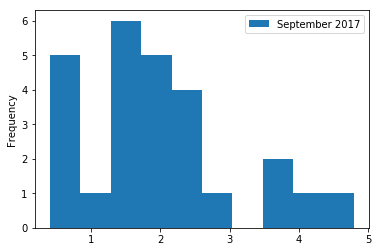

In [32]:
showmap("Schweizer", 'September 2017', True)

#### Map of Swiss people unemplyment, linear scale

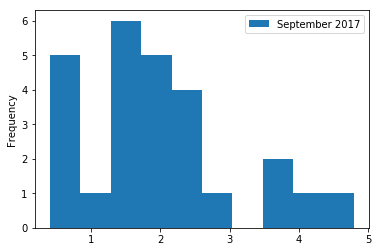

0.4


In [29]:
showmap("Schweizer", 'September 2017', False)

#### Non-swiss people unemployment, jenks scale

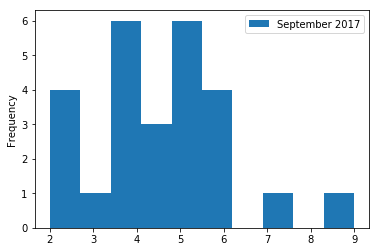

In [33]:
showmap("Ausländer", 'September 2017', True)

One way to display all the rates over the year is to make an interactive map that changes to show data for given month and nationality. Feel free to change any parameter.

In [35]:
monthChoice = widgets.Dropdown(
    options=suisse_nat_copy.keys(),
    value='September 2017',
    description='Month:',
    disabled=False,
)

nationalityChoice = widgets.RadioButtons(
    options=["Schweizer", "Ausländer"],
    value="Schweizer",
    description='Nationality:',
    disabled=False
)

thresholdChoice = widgets.Checkbox(
    value=False,
    description='Use jenks threshold',
    disabled=False
)

#display(monthChoice)
#display(nationalityChoice)
interact(showmap, nationality = nationalityChoice, month = monthChoice, splitSix = thresholdChoice)


interactive(children=(RadioButtons(description='Nationality:', options=('Schweizer', 'Ausländer'), value='Schweizer'), Dropdown(description='Month:', index=12, options=('September 2016', 'Oktober 2016', 'November 2016', 'Dezember 2016', 'Januar 2017', 'Februar 2017', 'März 2017', 'April 2017', 'Mai 2017', 'Juni 2017', 'Juli 2017', 'August 2017', 'September 2017'), value='September 2017'), Checkbox(value=False, description='Use jenks threshold'), Output()), _dom_classes=('widget-interact',))

<function __main__.showmap>

Now that we have the basic way of displaying the data with two maps done. Let's think how can we show the difference in uneployment based on nationality. One way could be the difference, however, looking at the data, that is not very promissing as it would be very small. Instead let's think back to the definition of unemplyment rate: it's the amount of unemployed people of that nationality per 100 active people of that nationality. Such definition gets rid of the bias due to increased ammount of Swiss people to non-Swiss people. Therefore we can compare the unemployment rates as ratio of one to another. That is to how many non-Swiss unemplyed people per 100 non-Swiss correponds one Swiss unemployed person in a hundred Swiss people. It is a hard metric to grasp but we find the final result to be demonstative. The drawback of this method is that it won't work if the non-Swiss unemployment is zero, but first of all, looking at the data it never is zero through out the year and also full employment has been proven imposible in economics. Another drawback is that the range for ratio under one is smaller then the range for over one. In our case Swiss unemployment is always smaller then the non-Swiss unemployment, therefore in this particular case, it is not a concern. Otherwise, as in a more general usage we can assume that quantile scale would take care of this drawback while displaying the data.

Therefore we start by extracting the unemplyment rate for Swiss people.

In [36]:
suisse_nat_ger_sept_sw = suisse_nat.copy()
suisse_nat_ger_sept_sw = suisse_nat_ger_sept_sw[suisse_nat_ger_sept_sw.Nationalität == "Schweizer"]
suisse_nat_ger_sept_sw = suisse_nat_ger_sept_sw[['Kanton', 'September 2017']]
suisse_nat_ger_sept_sw.head(5)

,Kanton,September 2017
1,Zürich,2.5
3,Bern/Berne,1.8
5,Luzern,1.3
7,Uri,0.4
9,Schwyz,1.2


Now we extract unemployment rate for the non-Swiss people.

In [37]:
suisse_nat_ger_sept_a = suisse_nat.copy()
suisse_nat_ger_sept_a = suisse_nat_ger_sept_a[suisse_nat_ger_sept_a.Nationalität == "Ausländer"]
suisse_nat_ger_sept_a = suisse_nat_ger_sept_a[['Kanton', 'September 2017']]
suisse_nat_ger_sept_a.head(5)

,Kanton,September 2017
0,Zürich,5.3
2,Bern/Berne,5.5
4,Luzern,3.9
6,Uri,2.1
8,Schwyz,3.4


Now let's merge the resultant dataframes on Cantons. Since they initially came from the same dataframe with a given set of cantons, the join is complete.

In [38]:
suisse_nat_ger_sept_ratio = pd.merge(suisse_nat_ger_sept_a, suisse_nat_ger_sept_sw, on='Kanton')
suisse_nat_ger_sept_ratio.head(5)

,Kanton,September 2017_x,September 2017_y
0,Zürich,5.3,2.5
1,Bern/Berne,5.5,1.8
2,Luzern,3.9,1.3
3,Uri,2.1,0.4
4,Schwyz,3.4,1.2


Finally let's calculate the ratio as defined above.

In [39]:
suisse_nat_ger_sept_ratio['Ratio'] = suisse_nat_ger_sept_ratio['September 2017_x'] / suisse_nat_ger_sept_ratio['September 2017_y']
suisse_nat_ger_sept_ratio.head(5)

,Kanton,September 2017_x,September 2017_y,Ratio
0,Zürich,5.3,2.5,2.120000
1,Bern/Berne,5.5,1.8,3.055556
2,Luzern,3.9,1.3,3.000000
3,Uri,2.1,0.4,5.250000
4,Schwyz,3.4,1.2,2.833333


And draw a map:)

In [43]:
suisse_topojson_path = os.path.join('topojson', 'ch-cantons.topojson.json')
results_map = folium.Map(
    location=[46.800, 8.3093],
    tiles='cartodbpositron',
    #tiles='Mapbox Bright',
    zoom_start=8
)

jenks_class = jenks(suisse_nat_ger_sept_ratio['Ratio'].values.copy(), 5)
jenks_class[0] = suisse_nat_ger_sept_ratio['Ratio'].min()

results_map.choropleth(
    open(suisse_topojson_path),
    data=suisse_nat_ger_sept_ratio,
    columns=['Kanton','Ratio'],
    key_on='feature.properties.name',
    topojson='objects.cantons',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Unemployment Ratio of non-Swiss people unemp. to Swiss people unemp.',
    threshold_scale=jenks_class,
    reset=True
)

folium.LayerControl().add_to(results_map)

results_map.save('data/ratioMap.html')

results_map

As a result we can see that more internationally friendly cantons such as Vaud, Geneva and Zurich emply more non-Swiss people and so the ratio is closer to 1. However it is much harder for international people to find work in more rural parts of Switzerland.

### Now let's have a look at the age groups
Due to the format of data on the Amstat website, we decided to choose the standart age separation as young (15 - 24) and aged (25 - above). It appears that these are clean-cut two different categories that are not mixed up in the unemployment rate calculation, and so make sense to be separated as age groups.

First let's start by loading the data.

In [44]:
suisse_jeunes_xls_data_path =  os.path.join('data', '2_2_Taux_de_ch%C3%B4mage des jeunes.xlsx')
suisse_nat_jeunes = pd.read_excel(suisse_jeunes_xls_data_path, sheetname='2.2 Taux de chômage des jeunes', header=3)
suisse_nat_jeunes.drop(['Mois'], axis=1, inplace = True)
suisse_nat_jeunes.head(5)

Septembre 2017
Zurich  Etrangers            5.8
        Suisses              3.2
Berne   Etrangers            7.7
        Suisses              2.2
Lucerne Etrangers            4.7

It needs some cleaning and reaindexing to look like the data for aged people.

In [45]:
suisse_nat_jeunes = suisse_nat_jeunes.reset_index()
suisse_nat_jeunes['Canton'] = suisse_nat_jeunes['level_0']
suisse_nat_jeunes.drop(['level_0'], axis=1, inplace = True)
suisse_nat_jeunes['Septembre 2017'].replace('...', np.nan, inplace = True)
suisse_nat_jeunes['Septembre 2017'] = pd.to_numeric(suisse_nat_jeunes['Septembre 2017'])
suisse_nat_jeunes.dtypes

level_1            object
Septembre 2017    float64
Canton             object
dtype: object

In [46]:
suisse_nat_jeunes.head(5)

,level_1,Septembre 2017,Canton
0,Etrangers,5.8,Zurich
1,Suisses,3.2,Zurich
2,Etrangers,7.7,Berne
3,Suisses,2.2,Berne
4,Etrangers,4.7,Lucerne


Now let's extract the data we are actually interested in and prepare it for merging.

In [47]:
suisse_nat_young_swiss = suisse_nat_jeunes[suisse_nat_jeunes.level_1 == 'Suisses']
suisse_nat_young_swiss = suisse_nat_young_swiss[['Canton', 'Septembre 2017']]
suisse_nat_young_swiss['Suisses_Young'] = suisse_nat_young_swiss['Septembre 2017']
suisse_nat_young_swiss.drop(['Septembre 2017'], axis=1, inplace = True)
suisse_nat_young_swiss.head(5)

,Canton,Suisses_Young
1,Zurich,3.2
3,Berne,2.2
5,Lucerne,1.7
7,Uri,0.3
9,Schwyz,1.2


In [48]:
suisse_nat_young_non_swiss = suisse_nat_jeunes[suisse_nat_jeunes.level_1 == 'Etrangers']
suisse_nat_young_non_swiss = suisse_nat_young_non_swiss[['Canton', 'Septembre 2017']]
suisse_nat_young_non_swiss['Etranger_Young'] = suisse_nat_young_non_swiss['Septembre 2017']
suisse_nat_young_non_swiss.drop(['Septembre 2017'], axis=1, inplace = True)
suisse_nat_young_non_swiss.head(5)

,Canton,Etranger_Young
0,Zurich,5.8
2,Berne,7.7
4,Lucerne,4.7
6,Uri,NaN
8,Schwyz,3.5


In [49]:
suisse_nat_young_merged = pd.merge(suisse_nat_young_non_swiss, suisse_nat_young_swiss, on='Canton')
suisse_nat_young_merged.head(5)

,Canton,Etranger_Young,Suisses_Young
0,Zurich,5.8,3.2
1,Berne,7.7,2.2
2,Lucerne,4.7,1.7
3,Uri,NaN,0.3
4,Schwyz,3.5,1.2


Now we do similar procedure to the aged people data. It is a bit different and not missing any values.

In [50]:
suisse_nat_aged_xls_data_path =  os.path.join('data', '2_1_Taux_de_ch_clean.xlsx')
suisse_nat_aged = pd.read_excel(suisse_nat_aged_xls_data_path, sheetname='2.1 Taux de chômage', header=5)
suisse_nat_aged.drop(['Mois'], axis=1, inplace = True)
suisse_nat_aged.drop(['Total'], axis=1, inplace = True)
suisse_nat_aged.head(5)

,Canton,Nationalité,Septembre 2016,Octobre 2016,Novembre 2016,Décembre 2016,Janvier 2017,Février 2017,Mars 2017,Avril 2017,Mai 2017,Juin 2017,Juillet 2017,Août 2017,Septembre 2017
0,Zurich,Etrangers,5.7,5.8,6.1,6.4,6.6,6.5,6.3,6.0,5.7,5.6,5.5,5.3,5.3
1,Zurich,Suisses,2.8,2.8,2.8,2.9,2.9,2.8,2.8,2.7,2.6,2.6,2.6,2.6,2.5
2,Berne,Etrangers,5.9,6.3,6.9,7.3,7.5,7.4,7.1,6.8,6.2,5.7,5.5,5.5,5.5
3,Berne,Suisses,2.0,2.0,2.0,2.1,2.2,2.1,2.1,2.0,1.9,1.8,1.8,1.9,1.8
4,Lucerne,Etrangers,4.2,4.2,4.6,5.1,5.4,5.1,4.8,4.6,4.3,4.1,3.9,3.9,3.9


In [51]:
suisse_nat_aged_swiss = suisse_nat_aged[suisse_nat_aged.Nationalité == 'Suisses']
suisse_nat_aged_swiss.head(5)

,Canton,Nationalité,Septembre 2016,Octobre 2016,Novembre 2016,Décembre 2016,Janvier 2017,Février 2017,Mars 2017,Avril 2017,Mai 2017,Juin 2017,Juillet 2017,Août 2017,Septembre 2017
1,Zurich,Suisses,2.8,2.8,2.8,2.9,2.9,2.8,2.8,2.7,2.6,2.6,2.6,2.6,2.5
3,Berne,Suisses,2.0,2.0,2.0,2.1,2.2,2.1,2.1,2.0,1.9,1.8,1.8,1.9,1.8
5,Lucerne,Suisses,1.4,1.4,1.4,1.5,1.5,1.5,1.4,1.3,1.3,1.2,1.3,1.3,1.3
7,Uri,Suisses,0.6,0.6,0.6,0.6,0.7,0.7,0.6,0.6,0.6,0.5,0.4,0.4,0.4
9,Schwyz,Suisses,1.2,1.2,1.2,1.3,1.4,1.4,1.3,1.2,1.2,1.1,1.2,1.2,1.2


In [52]:
suisse_nat_aged_swiss = suisse_nat_aged_swiss[['Canton', 'Septembre 2017']]
suisse_nat_aged_swiss['Suisses_Aged'] = suisse_nat_aged_swiss['Septembre 2017']
suisse_nat_aged_swiss.drop(['Septembre 2017'], axis=1, inplace = True)
suisse_nat_aged_swiss.head(5)

,Canton,Suisses_Aged
1,Zurich,2.5
3,Berne,1.8
5,Lucerne,1.3
7,Uri,0.4
9,Schwyz,1.2


In [53]:
suisse_nat_aged_non_swiss = suisse_nat_aged[suisse_nat_aged.Nationalité == 'Etrangers'][['Canton', 'Septembre 2017']]
suisse_nat_aged_non_swiss['Etranger_Aged'] = suisse_nat_aged_non_swiss['Septembre 2017']
suisse_nat_aged_non_swiss.drop(['Septembre 2017'], axis=1, inplace = True)
suisse_nat_aged_non_swiss.head(5)

,Canton,Etranger_Aged
0,Zurich,5.3
2,Berne,5.5
4,Lucerne,3.9
6,Uri,2.1
8,Schwyz,3.4


In [54]:
suisse_aged = pd.merge(suisse_nat_aged_swiss, suisse_nat_aged_non_swiss, on='Canton' )
suisse_aged.head(5)

,Canton,Suisses_Aged,Etranger_Aged
0,Zurich,2.5,5.3
1,Berne,1.8,5.5
2,Lucerne,1.3,3.9
3,Uri,0.4,2.1
4,Schwyz,1.2,3.4


Finally let's merge the two dataframes to get the final data for the bar plot.

In [55]:
suisse = pd.merge(suisse_aged, suisse_nat_young_merged, on='Canton')
suisse.index = suisse.Canton
suisse.head(5)

,Canton,Suisses_Aged,Etranger_Aged,Etranger_Young,Suisses_Young
Canton,,,,,
Zurich,Zurich,2.5,5.3,5.8,3.2
Berne,Berne,1.8,5.5,7.7,2.2
Lucerne,Lucerne,1.3,3.9,4.7,1.7
Uri,Uri,0.4,2.1,NaN,0.3
Schwyz,Schwyz,1.2,3.4,3.5,1.2


There is a lot of data to display, and it is going to be hard to read the bar chart. Therefore we plot each column in the bar plot so that details may be observed. Then we plot the bar plot with everything to show birdseye view of data.

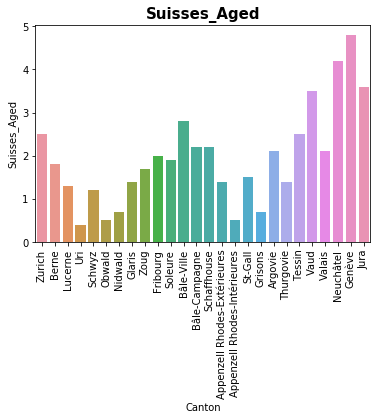

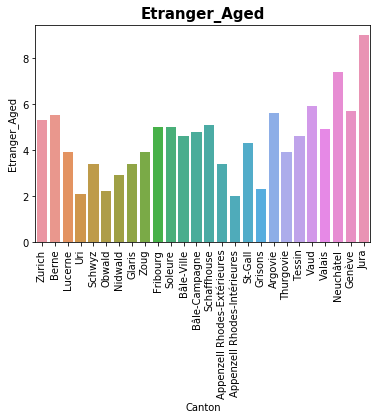

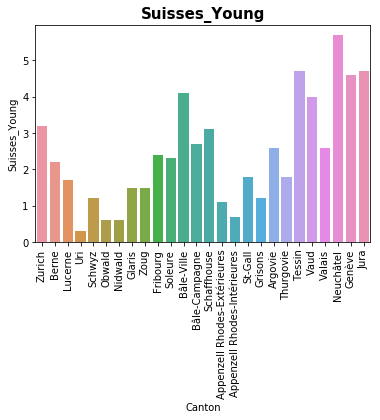

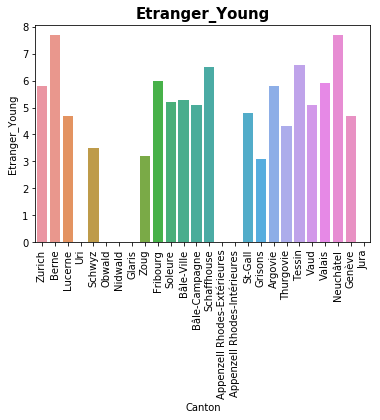

In [56]:
def plotBarChart(df, column):
    fig, ax = plt.subplots()
    ax.set_title(column, fontsize=15, fontweight='bold')
    sns.barplot(suisse['Canton'].keys(), suisse[column], ax=ax)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)
    plt.show()

plotBarChart(suisse, 'Suisses_Aged') 
plotBarChart(suisse, 'Etranger_Aged')
plotBarChart(suisse, 'Suisses_Young')
plotBarChart(suisse, 'Etranger_Young')

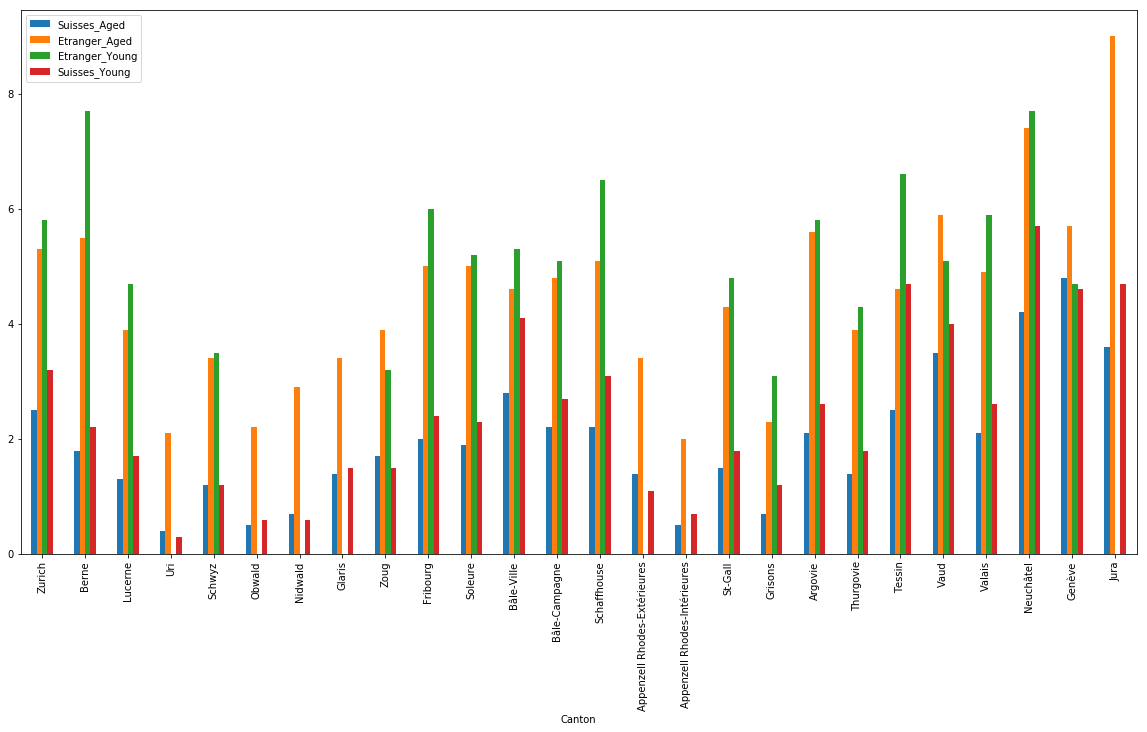

In [57]:
suisse.plot.bar(figsize=(20,10))
plt.show()